# Feature Selection

Consiste na redução da dimensionalidade (quantidade de colunas) do conjunto de amostras, com o objetivo de melhorar a capacidade preditiva dos modelos de aprendizado de máquina.

São diversos os benefícios do *feature selection*, dentre eles:

* Redução do gasto computacional
* Ganho em interpretabilidade dos resultados
* Reduzir multicolinearidade/redundância (duas features altamente correlacionadas)
* Remover features irrelevantes (que podem ser retiradas sem perda relevante de informação) 

Vale ressaltar a diferença entre *feature selection* e *feature extraction*. A seleção de variáveis independentes consiste em remover determinado conjunto de variáveis consideradas irrelevantes (Ex: SelectKBest). Já a extração envolve aplicar transformações lineares no conjunto de dados, de forma a reduzir a dimensionalidade por meio de funções matemáticas (Ex: PCA, t-SNE). **Ambas serão abordadas aqui como feature selection**. 

O módulo `sklearn.decomposition` agrupa diversas funções a serem utilizadas para *feature selection*. Nesse resumo serão abordadas as mais importantes. 

**Fonte:** <https://en.wikipedia.org/wiki/Feature_selection>

## Principais Ferramentas

In [ ]:
def get_dados(path = "dados//dados.xlsx", tipo_target = "num"):
    variaveis = pd.read_excel(path, sheet_name = "Dados Bons")
    variaveis.set_index("Data", inplace = True)
    variaveis.drop(index = pd.to_datetime("2000-01-01"), inplace = True)
    
    spy_ohlc_df = yf.download('SPY', start = '2000-01-01', interval = "3mo")
    spy_ohlc_df.dropna(inplace = True)
    spy_ohlc_df["Target"] = spy_ohlc_df["Adj Close"].pct_change(1)
    spy_ohlc_df = spy_ohlc_df["Target"]
    variaveis = variaveis.join(spy_ohlc_df)
    
    if tipo_target == "cat":
        target = variaveis["Target"] > 0
        variaveis["Retorno"] = variaveis["Target"]
        variaveis.drop("Target", axis = 1, inplace = True)
        variaveis["Target"] = target
    
    return variaveis
    
df = get_dados(tipo_target = "cat")

In [46]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Importando base de dados
df = pd.read_excel("./dados/features.xlsx", index_col="Data")
df_target = yf.download('SPY', start = '2000-01-01', interval = "3mo", progress=False).dropna()
df_target["SPX"] = df_target["Adj Close"].pct_change(1).shift(-1)
df = df.join(df_target["SPX"])

# Divisão treino-teste
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop("SPX", axis = 1)
y = df["SPX"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.7)

y_train_bin = np.where(y_train > 0, 1, 0)
y_test_bin = np.where(y_test > 0, 1, 0)

### SelectKBest

Seleciona as `K` melhores variáveis independentes com base no score obtido para um teste estatístico entre cada variável (x) e o alvo (y). 

Há diversos testes estatísticos passíveis de utilização, que variam conforme características da variável-alvo (discreta ou contínua). Dentre eles, estão:

##### Alvo Discreto

* **chi2:** Estatística qui-quadrado (só inclui features positivas)
* **f_classif:** Estatística F para classificação
* **mutual_info_classif:** *Mutual information* para classificação

##### Alvo Contínuo

* **f_regression:** Estatística F para regressão
* **mutual_info_regression:** *Mutual information* para regressão

In [31]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=5)
X_train_novo = selector.fit_transform(X_train, y_train)
X_test_novo = selector.transform(X_test)

print("Features Selecionadas:\n", list(X_train.columns[selector.get_support()]))

Features Selecionadas:
 ['Imports', 'Labor Productivity', 'NFIB Small Business Optimism', 'Industrial Production', 'CPI']


A função `SelectPercentile` funciona de maneira semelhante, estimando as n% (0 < n < 100) melhores features com base no mesmo teste estatístico, no lugar de K.

### Recursive Feature Elimination (RFE)

É um método iterativo que consiste no treinamento de um modelo no conjunto de dados que associa pesos para a importância de cada variável independente no processo (Ex: coeficientes de uma regressão linear ou random forest).

A partir daí, selecionamos as variáveis que serão eliminadas, e treinamos um novo modelo sem elas. Esse processo é feito de forma contínua a fim de eliminar as próximas variáveis, até que se sobre somente o número de variáveis desejado.

Argumentos importantes:

* **step:** define a quantidade de features a serem removidas após cada iteração. Se estiver entre 0 e 1, remove x% das features.

* **n_features_to_select:** define a quantidade final desejada de features ao final do processo.

In [49]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier()
selector = RFE(modelo, n_features_to_select=5, step = 1)
X_train_novo = selector.fit_transform(X_train, y_train_bin)
X_test_novo = selector.transform(X_test)

print("Features Selecionadas:\n", list(X_train.columns[selector.get_support()]))

Features Selecionadas:
 ['Real PCE', 'M1', 'Real Disposable', 'Personal Savings', 'Labor Productivity']


A função `RFECV` realiza o mesmo processo da RFE, porém estima o melhor modelo desejado em cada subconjunto de variáveis a partir do método de validação cruzada, a fim de obter mais acurácia nas eliminações de variáveis. 

In [52]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier()

selector = RFECV(modelo, min_features_to_select=5, step = 1, cv = 5, scoring="accuracy")
X_train_novo = selector.fit_transform(X_train, y_train_bin)
X_test_novo = selector.transform(X_test)

print("Features Selecionadas:\n", list(X_train.columns[selector.get_support()]))

Features Selecionadas:
 ['T-BOND', 'GDP Real', 'Real PCE', 'M1', 'Real Disposable', 'Personal Savings', 'Exports', 'Imports', 'Labor Productivity', 'NFIB Small Business Optimism', 'Industrial Production', 'CPI']


### Linear Discriminant Analysis (LDA)

A Análise Discriminante Linear é um método supervisionado de seleção de features que objetiva reduzir a dimensionalidade do banco de dados baseado em um uma projeção que maximiza a similaridade (proximidade) entre observações de mesma classe. 

Isso ocorre por meio da projeção que maximiza o termo $\frac{(\mu_{i} - \mu_{j})^2}{\sigma_{i}^2 + \sigma_{j}^2}$, onde:

* $\mu_{i}$ é a média dos valores obtidos para a categoria $i$ na projeção

* $\sigma_{i}$  é a variância dos valores obtidos para a categoria $i$ na projeção

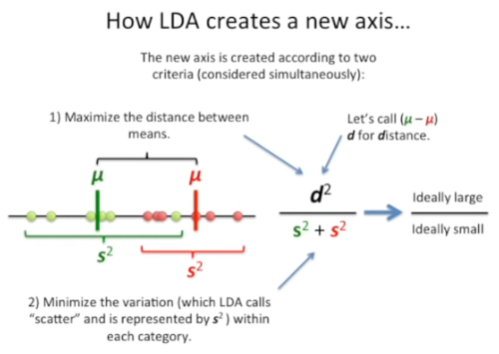

Para um dado número $n$ de classes a serem separadas, LDA cria $n-1$ novos eixos.

### Principal Component Analysis (PCA)

A Análise de Componentes Principais (também conhecida como Transformada de Hotelling ou Transformada Discreta de Karhunen-Loève) aplica uma transformação linear no conjunto de dados. A partir daí, são criadas novas variáveis com base nas antigas - chamadas de *componentes principais (PC)* - que são combinações lineares das variáveis originais ponderadas pela sua variância e que são completamente descorrelacionadas entre si *por definição*.

A PCA também separa os componentes mais importantes para que estejam nas primeiras dimensões (i.e nos eixos principais) com base no percentual da variância do banco de dados que está contido em cada eixo. Isso permite selecionar as variáveis que apresentam a maior parte do poder explicativo do banco de dados, e assim realizar previsões mais assertivas.

Objetivos:

* Descorrelacionar as variáveis
* Eliminar variáveis redundantes
* Eliminar informações aleatórias

**Obs.:** Para aplicar o método de PCA, é **crucial** garantir que todos os dados estejam em uma mesma escala. A utilização do `StandardScaler` é uma ótima forma de realizar essa operação. Além disso, vale ressaltar que o código de aplicação da PCA é semelhante ao do StandardScaler.

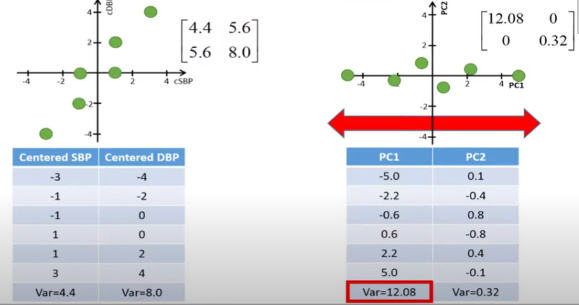

O argumento `n_components` define a quantidade de componentes principais que serão removidas após a aplicação da PCA, por possuírem baixo poder explicativo. Se este parâmetro estiver entre 0 e 1, mantém a menor quantidade de features que representa mais do que n% do poder explicativo do banco de dados.

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_novo = scaler.fit_transform(X_train)
X_test_novo = scaler.transform(X_test)

pca = PCA(n_components=0.95)
X_train_novo = pca.fit_transform(X_train_novo)
X_test_novo = pca.transform(X_test_novo)

print("Variância de cada componente em relação às demais:\n", pca.explained_variance_ratio_.round(3))

Variância de cada componente em relação às demais:
 [0.306 0.13  0.124 0.106 0.067 0.062 0.059 0.053 0.038 0.026]


### Kernel Principal Component Analysis (kPCA)

Tem por objetivo aplicar uma função denominada "Kernel" nas features, de forma a projetar problemas que não são linearmente separáveis para dimensões superiores, onde são linearmente separáveis. Assim, é possível auxiliar modelos a realizar classificações de maneira mais inteligível. 

A Análise de Componentes Principais é aplicada no novo conjunto de dados, e depois é aplicada uma transformação linear que converte os dados de volta para as suas dimensões originais. 

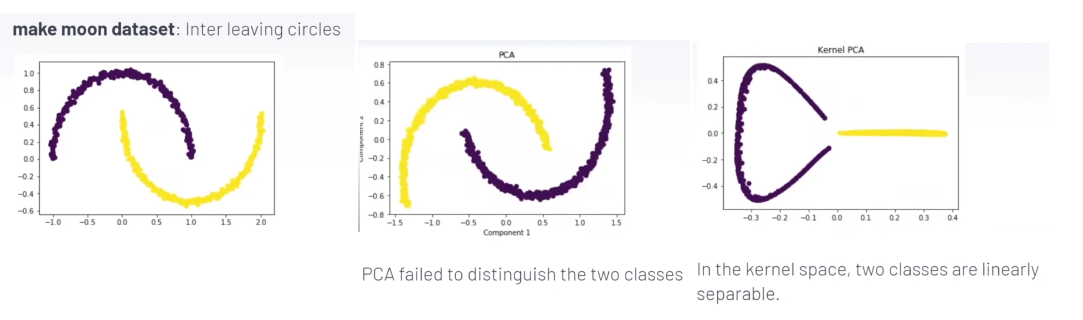

O "Truque do Kernel" consiste em não se fazer necessário criar todas as novas dimensões - i.e. transformações das features originais - para se fazer a PCA, o que demandaria um alto gasto computacional. Os Kernels definem uma função para o cálculo do **produto interno** entre as features originais, que é a única variável necessária para projetar o conjunto de dados n-dimensional na base de dados original. Assim, reduzimos a complexidade do código e podemos representar diversas transformações lineares em cima do nosso conjunto de dados original, caso contenham as propriedades de um Kernel.  

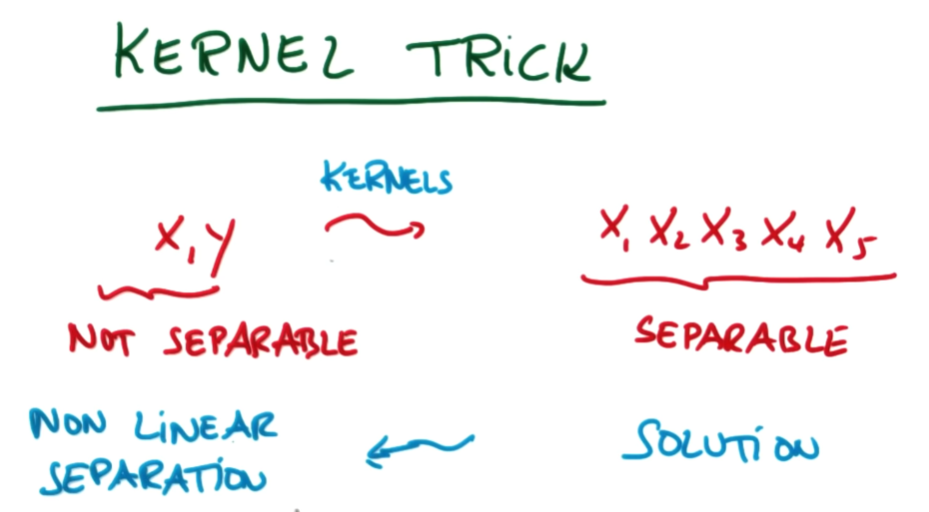

### T-Distributed Stochastic Neighbor Embedding (t-SNE)



É uma técnica redução de dimensionalidade (embedding) não-linear que permite a visualização de grandes conjuntos de dados em duas ou três dimensões. 

O t-SNE identifica as similaridades (distâncias escaladas pela função de probabilidade t-Student) entre os pares de observações, a fim de identificar vizinhos próximos. As distâncias obtidas para uma observação `x1` são divididas pela soma das distâncias entre `x1` todos as as outras observações, para identificar a proporção que a distância entre um par representa em relação à soma das distâncias obtidas entre todos os outros pares. Isso tem por objetivo escalar os dados para que sejam comparáveis, e seja mais fácil identificar os vizinhos próximos.

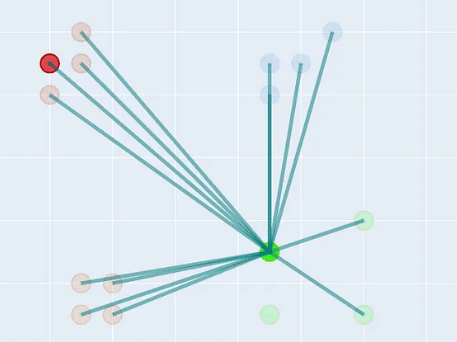

Por fim, o t-SNE gera um número `n` de componentes que irá gera novos valores randômicos que reproduzem os dados e preservam o máximo de similaridade entre eles, i.e, mantém a proximidade entre as observações vizinhas, dentro de novos eixos.

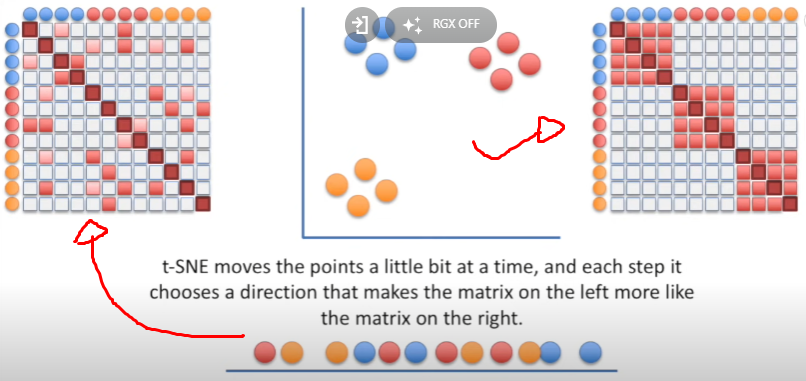

**Obs.:** Para aplicar o método de t-SNE, é necessário reduzir a quantidade de informações redundantes a fim de aumentar a qualidade do modelo. Por padrão, o `sklearn` utiliza a PCA para esse fim.

O método t-SNE é iterativo, portanto não é possível estimar seus parâmetros em um dataset (treino) e aplicar em outro (teste), como no caso da PCA, que é determinística (aplica a mesma matriz de covariância em dados externos). Ainda assim, o método t-SNE pode ser bem útil na visualização de dados de múltiplas dimensões.

In [83]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_train_novo = tsne.fit_transform(X_train)